<h1>Part 3 - Predictive Modeling</h1>

<h2>1. Problem Statement & Response</h2>

Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.
We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.
The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge.
1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?   
 <i>I explored the data based on categories of its variables (numerical, categorical, dates, etc) and tried to infer some relationships mostly via pair and count plots. Later on, I used these relationships to encode variables for tree ensemble and logistic regression analyses. For the analysis, I discarded around 1% of the data even though one of the variables (avg rating of driver) was missing at a 15% rate. I was able transfer some of that information to a new boolean variable and impute the missing values with a low figure from the variable's range. All of the code is below.
2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.   
 <i>I experimented with multiple classification models (Logistic Regression, Adaboost and Random Forest) and ended up choosing a Random Forest (RF) model with a max tree depth of 6 and an ensemble of 100. In selecting this model, I separated  my sample into training and test sets and performed grid searches with 5-fold cross-validation on training samples. The Random Forest seemed to present the best metrics across various scores while max tree depth of 6 was a good tradeoff between parsimony and performance (graphs and code below). The final model was trained on the whole Training set and scored on the Test set (Accuracy: 0.775, F1 Score: 0.662, Precision: 0.760, Recall: 0.586). My concerns are mostly about the data I imputed as well as the parsimony and interpretability of the RF model. I feel that I wasn't privy to a lot of the interaction between the variables due to implementation of the methodology. I also had concerns about the direction and 
significance of the feature importances. I tried to tackle this by running a Logistic Regression (LR) and analyzing its results.
     
     
3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long term rider retention (again, a few sentences will suffice).    
      <i>Based on both the Random Forest and Logistic Regression models we see that sign-up city (King's Landing > Winterfell >  Astopor), type of phone used (iPhone > Android) and being an ultimate-black-user (True > False) seem to be important factors in contributing to the probability of rider retention. All of these variables on their own are, however, not determined by the quality of service, but perhaps by demographics, wealth and possibly type of employment. A suggestion here could be to focus more on these demographics for growth and retention. Another suggestion could be to re-run this analysis excluding these groups and try to pinpoint what actual service features might correspond well with the rider retention. One feature that stands out as negative is the newly created "rider didnot rate" boolean which indicate that if a rider did not rate, then the probability of user loss would increase.

<h2>2. Data Description</h2>

|Variable | Description |
| :------ | :---------- |
| city| city this user signed up in
| phone| primary device for this user
| signup_date| date of account registration; in the form ‘YYYYMMDD’
| last_trip_date| the last time this user completed a trip; in the form ‘YYYYMMDD’
| avg_dist| the average distance in miles per trip taken in the first 30 days after signup
| avg_rating_by_driver| the rider’s average rating over all of their trips
| avg_rating_of_driver| the rider’s average rating of their drivers over all of their trips
| surge_pct| the percent of trips taken with surge multiplier > 1
| avg_surge| The average surge multiplier over all of this user’s trips
| trips_in_first_30_days| the number of trips this user took in the first 30 days after signing up
| ultimate_black_user| TRUE if the user took an Ultimate Black in their first 30 days; FALSE otherwise
| weekday_pct| the percent of the user’s trips occurring during a weekday

In [1]:
#import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, make_scorer
from sklearn.model_selection import GridSearchCV


<h2>3. Import Data, Generate Target Variables, Perform Train-Test Split

In [2]:
data_raw_fn = "ignore/ultimate_data_challenge.json"
data_raw_df = pd.read_json(data_raw_fn)

print("Data - Head")
data_raw_df.head()

Data - Head


,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [3]:
data_raw_df.dtypes

city                       object
trips_in_first_30_days      int64
signup_date                object
avg_rating_of_driver      float64
avg_surge                 float64
last_trip_date             object
phone                      object
surge_pct                 float64
ultimate_black_user          bool
weekday_pct               float64
avg_dist                  float64
avg_rating_by_driver      float64
dtype: object

In [4]:
data_raw_df['last_trip_date'] = data_raw_df['last_trip_date'].astype('datetime64[ns]');
data_raw_df['signup_date'] = data_raw_df['signup_date'].astype('datetime64[ns]');
data_raw_df.dtypes

city                              object
trips_in_first_30_days             int64
signup_date               datetime64[ns]
avg_rating_of_driver             float64
avg_surge                        float64
last_trip_date            datetime64[ns]
phone                             object
surge_pct                        float64
ultimate_black_user                 bool
weekday_pct                      float64
avg_dist                         float64
avg_rating_by_driver             float64
dtype: object

In [5]:
data_raw_df.isna().sum()

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
dtype: int64

At this stage, NA's in phone and avg_rating_by_driver are not large compared to the sample so I'll remove them from the sample. I will get to avg_rating_of_driver in the following part.

**Generate Target Variable**  
Assumption here is that the largest value of last_trip_date variable is close to the date we'd like to perform the analysis on ("as of" date of the analysis).

In [6]:
data_df = data_raw_df.copy() 
data_df['active'] = (data_raw_df['last_trip_date'] > (data_raw_df['last_trip_date'].max() - datetime.timedelta(days=30))).astype(np.int64)
data_df.active.head()

0    1
1    0
2    0
3    1
4    0
Name: active, dtype: int64

**Perform Train-Test Split**  
Perform this early at this stage so that we don't peek at the test data in the EDA phase. 

In [7]:
X_train, X_test, y_train, y_test = train_test_split(data_df.drop(columns = ['active']), data_df['active'], test_size = 0.20, shuffle=True)
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

**Continue Analyzing the Data - Train Split Only**

In [8]:
train.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,active
count,40000.000000,33489.000000,40000.000000,40000.000000,40000.000000,40000.000000,39849.000000,40000.000000
mean,2.289175,4.599418,1.074545,8.829672,60.764253,5.780523,4.777897,0.366575
std,3.816617,0.618338,0.223105,19.906211,37.102278,5.604267,0.444860,0.481875
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.430000,4.700000,0.000000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000,0.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000,1.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,77.130000,5.000000,1.000000


In [9]:
train.select_dtypes(exclude = [np.float64, np.int64])

,city,signup_date,last_trip_date,phone,ultimate_black_user
12217,King's Landing,2014-01-31,2014-04-06,iPhone,False
11607,King's Landing,2014-01-18,2014-06-07,iPhone,False
33280,Winterfell,2014-01-16,2014-05-17,iPhone,False
36549,Astapor,2014-01-27,2014-02-06,Android,True
6971,Astapor,2014-01-08,2014-02-16,iPhone,False
...,...,...,...,...,...
37086,Winterfell,2014-01-30,2014-06-15,Android,True
23955,Winterfell,2014-01-12,2014-05-27,iPhone,False
15706,King's Landing,2014-01-25,2014-06-20,iPhone,False
26556,Winterfell,2014-01-10,2014-01-11,iPhone,True


In [10]:
num_vars = list(train.select_dtypes(include=[np.float64, np.int64]).columns)
date_vars = list(train.select_dtypes(include=['datetime64[ns]']).columns)
boolcat_vars = list(train.select_dtypes(include=['bool', 'object']).columns)

print(num_vars)
print(date_vars)
print(boolcat_vars)


['trips_in_first_30_days', 'avg_rating_of_driver', 'avg_surge', 'surge_pct', 'weekday_pct', 'avg_dist', 'avg_rating_by_driver', 'active']
['signup_date', 'last_trip_date']
['city', 'phone', 'ultimate_black_user']


<h2>4. Explore Variables</h2>

<h3>Explore Numerical Variables</h3>

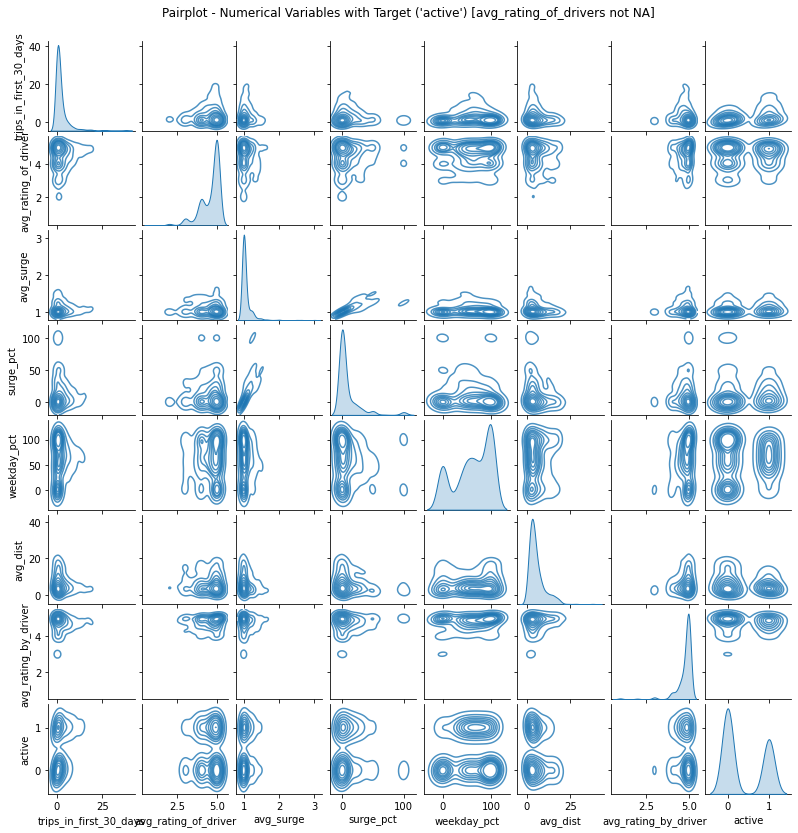

In [11]:
sns.pairplot(train[num_vars].sample(500),plot_kws={'alpha':0.8}, dropna=True, kind='kde')
plt.gcf().set_size_inches(11,11)
plt.suptitle('Pairplot - Numerical Variables with Target (\'active\') [avg_rating_of_drivers not NA]', y=1.03);


**Some Notes on Distribution (when avg_rating_of_driver is not NA)**
<li>More trips in first 30 days tend to result more active users.
<li>Percent of trips taken on a weekday seems bimodal. Lower hump is more associated inactive users. More weekday trips tend to result in more active users.
<li>Active users tend to have tighter distribution of average distance traveled, tend to be rated lower by the drivers and tend to be less sensitive to surge percentage. (Maybe a group of active users are business users)

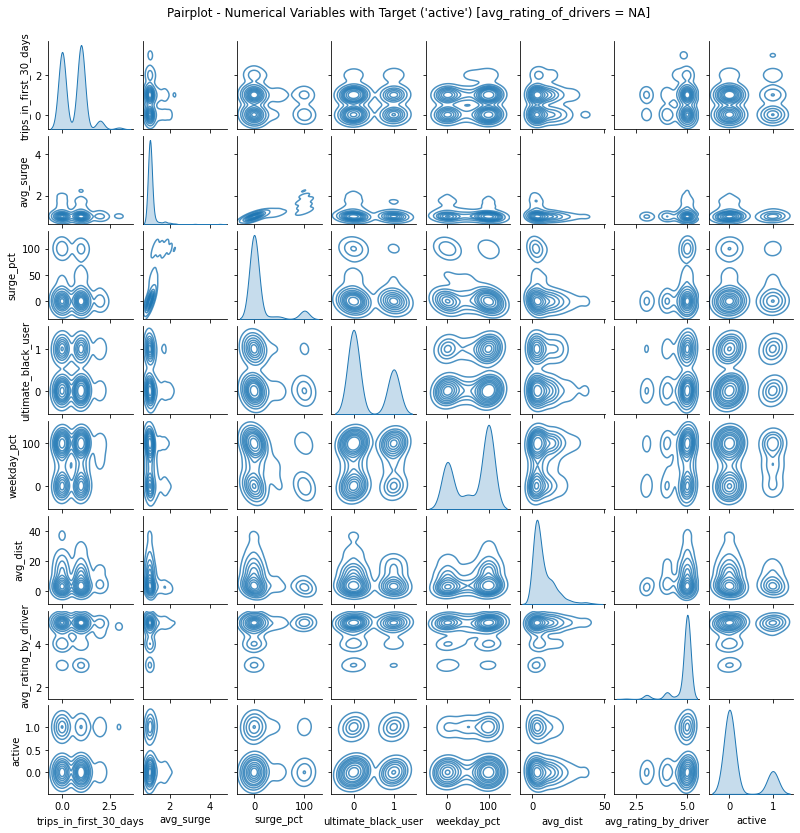

In [12]:
_avg_rod_NA = train['avg_rating_of_driver'].isna()
_train_avg_rod_NA = train[_avg_rod_NA].drop(columns=['avg_rating_of_driver'])
sns.pairplot(_train_avg_rod_NA.sample(300),plot_kws={'alpha':0.8}, kind='kde')
plt.gcf().set_size_inches(11,11)
plt.suptitle('Pairplot - Numerical Variables with Target (\'active\') [avg_rating_of_drivers = NA]', y=1.03);

**Some Notes Comparing Distributions when avg_rating_of_driver is NA vs not NA)**
<li>On its own, when a rider doesn't rate their driver, it's much more likely that they will not be active. This feature should somehow be incorporated in the the model. We probably shouldn't discard this variable. 
    
<li>Suggestion: We could run two separate models (in case of logistic regression) OR we could add a new boolean variable called "rider_didnot_rate" in to the model and replace all NAs 10 percentile rating. I am surmising that the second approach will add more information to the model (bool: rider_didnot_rate) than it will take away (replace NAs with 10 percentile rating). We can test this. 

<h3>Explore Date Variables</h3>

These variables will not be of much use to us in a static setting.   
Last trip date has one-to-one correspondence with the target (i.e. <30days from today implies Active)  and 
Signup time of month will probably not be informative. But let's check it out.

Power_divergenceResult(statistic=array([4609.52086497]), pvalue=array([0.]))


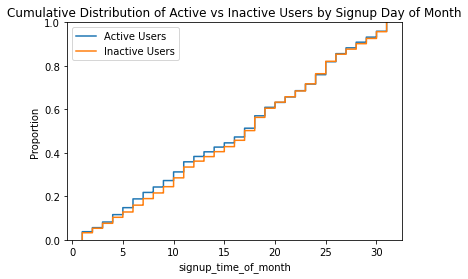

In [13]:
#Drop variable with mapping to target variable
train.drop(columns = ['last_trip_date'], inplace=True)
test.drop(columns = ['last_trip_date'], inplace=True)

train['signup_time_of_month'] = X_train['signup_date'].dt.day
test['signup_time_of_month'] = X_test['signup_date'].dt.day

train.drop(columns = ['signup_date'], inplace=True)
test.drop(columns = ['signup_date'], inplace=True)

_active = y_train == 1
ax = sns.ecdfplot(train['signup_time_of_month'][_active])
sns.ecdfplot(train['signup_time_of_month'][~_active])
plt.legend(['Active Users', 'Inactive Users'])
plt.title('Cumulative Distribution of Active vs Inactive Users by Signup Day of Month')

from scipy.stats import chisquare
signup_time_active = train[_active].groupby(by=['signup_time_of_month'])['signup_time_of_month'].agg(['count']).sort_index()
signup_time_inactive = train[~_active].groupby(by=['signup_time_of_month'])['signup_time_of_month'].agg(['count']).sort_index()

print(chisquare(signup_time_active, f_exp=signup_time_inactive))

Although the distributions look similar, we cannot reject the null hypothesis that the distributions are the same.   One positive aspect of this variable is that it is somewhat monotonic with more active signups coming up at the beginning of the month.  
I am still passing on this variable for now due to the fact that individual days in a month have 31 categories. I've also tried weekdays and still have no real visible differences but can reject the null hypothesis with the test.



In [14]:
train.drop(columns = ['signup_time_of_month'], inplace=True)
test.drop(columns = ['signup_time_of_month'], inplace=True)

<h3>Explore Boolean and Categorical Variables</h3>

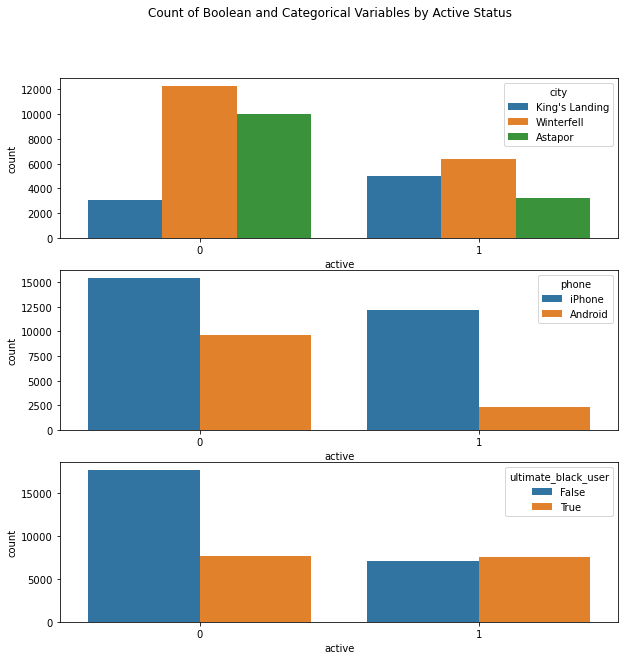

In [15]:
cols = len(boolcat_vars) 
fig, ax = plt.subplots(cols,1)
for _i, _v in enumerate(boolcat_vars):
    sns.countplot(data = train[boolcat_vars + ['active']], x='active', hue=_v, ax=ax[_i] )
fig.set_size_inches(10,10)
plt.suptitle('Count of Boolean and Categorical Variables by Active Status');


Data above is interesting.   
With respect to city, users from King's Landing, Winterfell and Astapor are more likely to be retained, respectively.   
With respect to phone, iPhone users are more likely to be retained than Android users.   
With respect to Ultimate Black User status, users with the service are more likely to be retained.   

Now, let's encode these variables.

In [16]:
train_cat = train.copy()
test_cat = test.copy()

city_mapper = {'Astapor': 0, 'Winterfell':1, 'King\'s Landing': 2}
phone_mapper = {'Android': 0, 'iPhone': 1}
ultimate_black_user_mapper = {False:0, True:1}

train_cat['city'] = train_cat['city'].map(city_mapper)
train_cat['phone'] = train_cat['phone'].map(phone_mapper)
train_cat['ultimate_black_user'] = train_cat['ultimate_black_user'].map(ultimate_black_user_mapper)

test_cat['city'] = test_cat['city'].map(city_mapper)
test_cat['phone'] = test_cat['phone'].map(phone_mapper)
test_cat['ultimate_black_user'] = test_cat['ultimate_black_user'].map(ultimate_black_user_mapper)

Let's insert a new categorical variable for "rider_didnot_rate" and replace the NaN's in "avg_rating_of_driver" by the 10th percentile figure. As  mentioned above, the assumption here is that the addition of this boolean variable and inclusion of 15% of data will be more beneficial than imputation of the average rating of driver feature. Eventually, this will need to be double-checked.

In [17]:
train_cat['rider_didnot_rate'] = train_cat['avg_rating_of_driver'].isna().map(lambda x: 1 if x==True else 0)
test_cat['rider_didnot_rate'] = test_cat['avg_rating_of_driver'].isna().map(lambda x: 1 if x==True else 0)

percentile_10 = np.percentile(train_cat['avg_rating_of_driver'][train_cat['avg_rating_of_driver'].notna()],10)
print('Missing Ration of Drivers replaced with 10th percentile rating: {0:.2f}\n'.format(percentile_10))

train_cat_nona = train_cat.copy()
test_cat_nona = test_cat.copy()

train_cat_nona['avg_rating_of_driver'].fillna(percentile_10, inplace=True)
test_cat_nona['avg_rating_of_driver'].fillna(percentile_10, inplace=True)

train_cat_nona.dropna(inplace=True)
test_cat_nona.dropna(inplace=True)

print('Number of NAs in final variables:')
print(train_cat_nona.isna().sum())
print(train_cat_nona.shape)
print(train_cat_nona.dtypes)


Missing Ration of Drivers replaced with 10th percentile rating: 4.00

Number of NAs in final variables:
city                      0
trips_in_first_30_days    0
avg_rating_of_driver      0
avg_surge                 0
phone                     0
surge_pct                 0
ultimate_black_user       0
weekday_pct               0
avg_dist                  0
avg_rating_by_driver      0
active                    0
rider_didnot_rate         0
dtype: int64
(39534, 12)
city                        int64
trips_in_first_30_days      int64
avg_rating_of_driver      float64
avg_surge                 float64
phone                     float64
surge_pct                 float64
ultimate_black_user         int64
weekday_pct               float64
avg_dist                  float64
avg_rating_by_driver      float64
active                      int64
rider_didnot_rate           int64
dtype: object


<h2>5. Modeling</h2>

<h3>Logistic Regression to Calibrate Training set</h3>

In [18]:
clf_lr = LogisticRegression(max_iter=2000)
param_grid_lr = {'penalty' : ['none', 'l1', 'l2', 'elastic_net'], 'solver' :['lbfgs', 'saga']}
scorer= {'f1_score':make_scorer(f1_score), 
             'precision_score':make_scorer(precision_score),
             'recall_score':make_scorer(recall_score),
             'accuracy_score':make_scorer(accuracy_score)}

# clf_lr_cv = GridSearchCV(clf_lr, param_grid_lr, cv=5, n_jobs=-1, scoring = scorer, refit='f1_score', verbose=3)
clf_lr_cv = GridSearchCV(clf_lr,  param_grid_lr,cv=5, n_jobs=-1, scoring = scorer, refit='f1_score', verbose=3)
clf_lr_cv.fit(train_cat_nona.drop(columns=['active'], axis=1),train_cat_nona['active']);


Fitting 5 folds for each of 8 candidates, totalling 40 fits


/Users/artun/envs/miniforge3/envs/junk391/lib/python3.9/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.57804239 0.57791501        nan 0.57792825 0.57812389 0.5780389
        nan        nan]
  warnings.warn(
/Users/artun/envs/miniforge3/envs/junk391/lib/python3.9/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.67177731 0.67131003        nan 0.67146725 0.67212013 0.67152548
        nan        nan]
  warnings.warn(
/Users/artun/envs/miniforge3/envs/junk391/lib/python3.9/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.50729525 0.50736407        nan 0.50729525 0.50722643 0.5074329
        nan        nan]
  warnings.warn(
/Users/artun/envs/miniforge3/envs/junk391/lib/python3.9/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite

In [19]:
clf_lr_cv_results = pd.DataFrame(clf_lr_cv.cv_results_).dropna()
clf_lr_cv_results


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_penalty,param_solver,params,split0_test_f1_score,split1_test_f1_score,split2_test_f1_score,...,std_test_recall_score,rank_test_recall_score,split0_test_accuracy_score,split1_test_accuracy_score,split2_test_accuracy_score,split3_test_accuracy_score,split4_test_accuracy_score,mean_test_accuracy_score,std_test_accuracy_score,rank_test_accuracy_score
0,1.264954,0.152055,0.011992,0.004304,none,lbfgs,"{'penalty': 'none', 'solver': 'lbfgs'}",0.581263,0.589638,0.589503,...,0.013055,3,0.729227,0.734539,0.734918,0.723789,0.716797,0.727854,0.006859,2
1,7.080222,0.248786,0.008542,0.002526,none,saga,"{'penalty': 'none', 'solver': 'saga'}",0.581754,0.589132,0.590170,...,0.013447,2,0.729227,0.734160,0.735298,0.723789,0.715912,0.727677,0.007156,5
3,7.602151,0.708343,0.008045,0.002323,l1,saga,"{'penalty': 'l1', 'solver': 'saga'}",0.581477,0.589247,0.590010,...,0.013353,3,0.729101,0.734286,0.735298,0.723916,0.716038,0.727728,0.007119,4
4,0.996286,0.168748,0.010062,0.002133,l2,lbfgs,"{'penalty': 'l2', 'solver': 'lbfgs'}",0.581150,0.590100,0.589342,...,0.013000,5,0.729101,0.735045,0.734918,0.723789,0.717050,0.727981,0.006875,1
5,5.067892,0.115317,0.005882,0.000196,l2,saga,"{'penalty': 'l2', 'solver': 'saga'}",0.581754,0.589247,0.590286,...,0.013435,1,0.729227,0.734286,0.735424,0.723916,0.716038,0.727778,0.007151,3


Maximum f1 score seems to be ~.57 across l1, l2 and regular logistic regressions.

<h3>Random Forests to Calibrate the Training Set<\h3>

In [20]:
max_depth_param = 15
param_grid_rf = {'max_depth':list(range(1, max_depth_param + 1))} #default n_estimators for Random Forest is 100.
clf_rf = RandomForestClassifier()

scorer= {'f1_score':make_scorer(f1_score), 
             'precision_score':make_scorer(precision_score),
             'recall_score':make_scorer(recall_score),
             'accuracy_score':make_scorer(accuracy_score)}
clf_rf_cv = GridSearchCV(clf_rf, param_grid_rf, cv=5, n_jobs=-1, scoring = scorer, refit='f1_score', verbose=3)
clf_rf_cv.fit(train_cat_nona.drop(['active'], axis=1),train_cat_nona['active']);

Fitting 5 folds for each of 15 candidates, totalling 75 fits


In [21]:
clf_rf_cv_results = pd.DataFrame(clf_rf_cv.cv_results_)
clf_rf_cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_f1_score,split1_test_f1_score,split2_test_f1_score,split3_test_f1_score,...,std_test_recall_score,rank_test_recall_score,split0_test_accuracy_score,split1_test_accuracy_score,split2_test_accuracy_score,split3_test_accuracy_score,split4_test_accuracy_score,mean_test_accuracy_score,std_test_accuracy_score,rank_test_accuracy_score
0,0.503620,0.015294,0.029416,0.004083,1,{'max_depth': 1},0.199573,0.211544,0.471983,0.463838,...,0.100498,15,0.668269,0.670039,0.712786,0.718730,0.698963,0.693757,0.021095,15
1,0.636088,0.009051,0.046735,0.005500,2,{'max_depth': 2},0.529112,0.517897,0.525921,0.523735,...,0.003376,14,0.730998,0.724042,0.728216,0.729733,0.729952,0.728588,0.002441,14
2,0.795776,0.010296,0.048154,0.002542,3,{'max_depth': 3},0.566724,0.568761,0.558824,0.571490,...,0.005373,13,0.743771,0.743013,0.742001,0.749842,0.744877,0.744701,0.002737,13
3,0.930497,0.023334,0.054998,0.002212,4,{'max_depth': 4},0.609250,0.600702,0.586286,0.608822,...,0.010304,12,0.759580,0.755533,0.750474,0.762236,0.761573,0.757879,0.004379,12
4,1.073962,0.010292,0.060389,0.001182,5,{'max_depth': 5},0.657071,0.649300,0.640853,0.658565,...,0.007986,11,0.777033,0.771848,0.770077,0.779689,0.776119,0.774953,0.003508,11
5,1.223185,0.030580,0.065637,0.005789,6,{'max_depth': 6},0.667943,0.662204,0.659175,0.672384,...,0.007076,10,0.780574,0.776654,0.777539,0.782598,0.778396,0.779152,0.002159,10
6,1.341909,0.018622,0.075734,0.003056,7,{'max_depth': 7},0.684799,0.669943,0.669716,0.680374,...,0.010355,9,0.786012,0.779183,0.780827,0.783736,0.781432,0.782238,0.002386,9
7,1.480903,0.024863,0.084641,0.002692,8,{'max_depth': 8},0.689540,0.682692,0.678504,0.684526,...,0.007295,8,0.788289,0.782977,0.784748,0.787024,0.780926,0.784793,0.002663,8
8,1.644180,0.034104,0.091384,0.006738,9,{'max_depth': 9},0.694784,0.686156,0.691922,0.691707,...,0.002117,7,0.791324,0.784115,0.790186,0.790312,0.784847,0.788157,0.003036,4
9,1.772715,0.018425,0.102418,0.003436,10,{'max_depth': 10},0.695796,0.691776,0.690802,0.693817,...,0.004349,6,0.790439,0.785759,0.788289,0.790818,0.784088,0.787879,0.002616,5


<h3>Adaboost to Calibrate the Training Set<\h3>

In [22]:
param_grid_ada = {'base_estimator__max_depth':list(range(1, max_depth_param + 1)), 'n_estimators':[100]}
clf_tree = DecisionTreeClassifier()
clf_ada = AdaBoostClassifier(clf_tree)
clf_ada_cv = GridSearchCV(clf_ada, param_grid_ada, cv=5, n_jobs=-1, scoring = scorer, refit='f1_score', verbose=3)
clf_ada_cv.fit(train_cat_nona.drop(['active'], axis=1),train_cat_nona['active'])

Fitting 5 folds for each of 15 candidates, totalling 75 fits


GridSearchCV(cv=5,
             estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier()),
             n_jobs=-1,
             param_grid={'base_estimator__max_depth': [1, 2, 3, 4, 5, 6, 7, 8,
                                                       9, 10, 11, 12, 13, 14,
                                                       15],
                         'n_estimators': [100]},
             refit='f1_score',
             scoring={'accuracy_score': make_scorer(accuracy_score),
                      'f1_score': make_scorer(f1_score),
                      'precision_score': make_scorer(precision_score),
                      'recall_score': make_scorer(recall_score)},
             verbose=3)

In [23]:
clf_ada_cv_results = pd.DataFrame(clf_ada_cv.cv_results_)
clf_ada_cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_base_estimator__max_depth,param_n_estimators,params,split0_test_f1_score,split1_test_f1_score,split2_test_f1_score,...,std_test_recall_score,rank_test_recall_score,split0_test_accuracy_score,split1_test_accuracy_score,split2_test_accuracy_score,split3_test_accuracy_score,split4_test_accuracy_score,mean_test_accuracy_score,std_test_accuracy_score,rank_test_accuracy_score
0,1.479407,0.023578,0.067998,0.007219,1,100,"{'base_estimator__max_depth': 1, 'n_estimators...",0.692830,0.683786,0.682819,...,0.005235,4,0.788162,0.781965,0.783104,0.788921,0.784088,0.785248,0.002782,2
1,2.178731,0.053416,0.067312,0.010202,2,100,"{'base_estimator__max_depth': 2, 'n_estimators...",0.699763,0.697977,0.701284,...,0.005087,1,0.791956,0.788542,0.794106,0.791451,0.781052,0.789422,0.004546,1
2,2.934280,0.024157,0.069022,0.005135,3,100,"{'base_estimator__max_depth': 3, 'n_estimators...",0.698367,0.690811,0.688609,...,0.004834,2,0.789807,0.782977,0.784621,0.784874,0.781685,0.784793,0.002762,3
3,3.672068,0.016973,0.073945,0.005783,4,100,"{'base_estimator__max_depth': 4, 'n_estimators...",0.685652,0.678899,0.679128,...,0.005980,3,0.780827,0.774251,0.778551,0.778045,0.772831,0.776901,0.002934,4
4,4.424363,0.018708,0.072476,0.003443,5,100,"{'base_estimator__max_depth': 5, 'n_estimators...",0.670136,0.665950,0.657876,...,0.006664,5,0.767548,0.764133,0.760465,0.765145,0.758538,0.763166,0.003249,5
5,5.230397,0.033358,0.081065,0.003719,6,100,"{'base_estimator__max_depth': 6, 'n_estimators...",0.632998,0.654898,0.639756,...,0.012490,8,0.741748,0.752751,0.746048,0.743392,0.748545,0.746497,0.003891,6
6,6.098597,0.033505,0.089726,0.002893,7,100,"{'base_estimator__max_depth': 7, 'n_estimators...",0.620506,0.629493,0.618007,...,0.007473,13,0.728974,0.732768,0.727963,0.727583,0.728814,0.729220,0.001848,13
7,6.912773,0.017843,0.094795,0.002992,8,100,"{'base_estimator__max_depth': 8, 'n_estimators...",0.602393,0.612886,0.609183,...,0.005735,15,0.714177,0.719616,0.717971,0.717339,0.713003,0.716421,0.002456,15
8,7.752876,0.045540,0.106713,0.005783,9,100,"{'base_estimator__max_depth': 9, 'n_estimators...",0.607356,0.606921,0.614711,...,0.005770,14,0.716454,0.719868,0.721766,0.719110,0.722363,0.719912,0.002100,14
9,8.312853,0.053248,0.118173,0.004158,10,100,"{'base_estimator__max_depth': 10, 'n_estimator...",0.626302,0.617319,0.622333,...,0.003879,12,0.732263,0.726698,0.731377,0.734792,0.725525,0.730131,0.003488,12


<h3>Model Selection</h3>

<ipython-input-24-fd075a961f66>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  clf_lr_cv_results_none_lbfgs = clf_lr_cv_results[clf_lr_cv_results['param_penalty']=='none'][clf_lr_cv_results['param_solver']=='lbfgs']


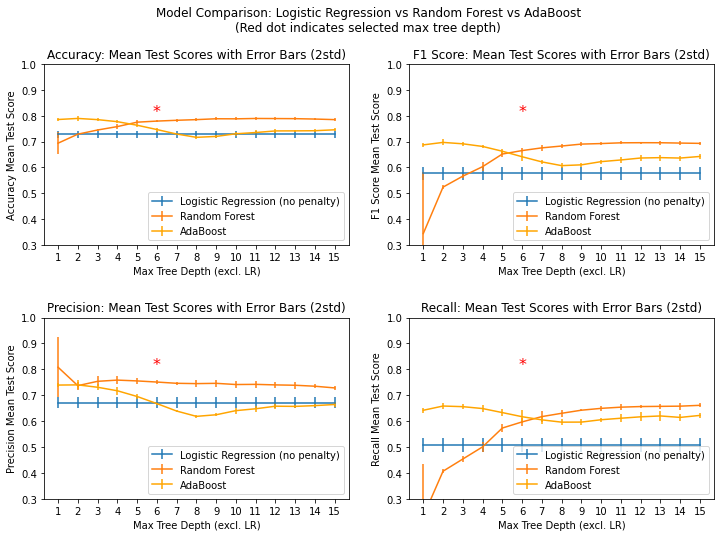

In [24]:
clf_lr_cv_results['Method'] = 'LR'
#print(clf_lr_cv_results)
clf_lr_cv_results_none_lbfgs = clf_lr_cv_results[clf_lr_cv_results['param_penalty']=='none'][clf_lr_cv_results['param_solver']=='lbfgs']
#print(clf_lr_cv_results_none_lbfgs)
#clf_rf_cv_results['Max Tree Depth'] = list(range(1, max_depth_param+1))

clf_rf_cv_results['Method'] = 'RF'
clf_rf_cv_results['Max Tree Depth'] = list(range(1, max_depth_param+1))

clf_ada_cv_results['Method'] = 'AdaBoost'
clf_ada_cv_results['Max Tree Depth'] = list(range(1, max_depth_param+1))


combined_cv_results = pd.concat([clf_ada_cv_results, clf_rf_cv_results, clf_lr_cv_results_none_lbfgs])
# print(combined_cv_results)

score_list = [[['mean_test_accuracy_score', 'std_test_accuracy_score', 'Accuracy'],
               ['mean_test_f1_score', 'std_test_f1_score', 'F1 Score']],
              [['mean_test_precision_score', 'std_test_precision_score', 'Precision'],
               ['mean_test_recall_score', 'std_test_recall_score', 'Recall']]]


def plot_scores_rf_ada(df, score_var_name, error_var_name, scorer_name, ax):
    rng = len(df)//2

    ax.errorbar(list(range(0,rng)), 
                [df[df['Method']=='LR'][score_var_name].values]*rng, 
                yerr = 2*combined_cv_results[combined_cv_results['Method']=='LR'][error_var_name].values*np.ones(rng))
    ax.errorbar(list(range(0,rng)), 
                df[df['Method']=='RF'][score_var_name],
                yerr = 2*df[df['Method']=='RF'][error_var_name])
    ax.errorbar(list(range(0,rng)), 
                 df[df['Method']=='AdaBoost'][score_var_name],
                yerr = 2*df[df['Method']=='AdaBoost'][error_var_name],
                color = 'orange')
    ax.set_xticks(range(0, 15))
    ax.set_xticklabels(range(1, 16))
    ax.set_ylim(0.3, 1)
    ax.set_xlabel('Max Tree Depth (excl. LR)')
    ax.set_ylabel(scorer_name+' Mean Test Score')
    ax.legend(['Logistic Regression (no penalty)', 'Random Forest', 'AdaBoost'], loc='lower right')
    ax.set_title(scorer_name+': Mean Test Scores with Error Bars (2std)')
    
combined_cv_results
fig, ax = plt.subplots(2,2)
fig.set_size_inches(12, 8)
plt.subplots_adjust(hspace=0.4)
plt.suptitle("Model Comparison: Logistic Regression vs Random Forest vs AdaBoost\n(Red dot indicates selected max tree depth)")

for _i in range(0, 2):
    for _j in range(0, 2):
        plot_scores_rf_ada(combined_cv_results, 
                           score_list[_i][_j][0], 
                           score_list[_i][_j][1], 
                           score_list[_i][_j][2], 
                           ax[_i][_j])
        ax[_i][_j].annotate(text = '*', size=16,
                            xy=[4.8, 0.8], color = 'red')
                                
                                
                                
                                

Among the above models, I find the Random Forest Max Tree Depth = 6 model to be the most promising. While it outperforms the other models in almost all of the metrics, it also has some parsimony compared to models of larger depth.   
LR model is not able to perform as well as the other models but that seems expected as it's probably a little too rigid to extract some of the joint relationships in the data. However it may still lead us to some valuable understandings about the active ridership question.

<h3>Retrain On All Available Using Final Random Forests Model on Training Data and Display Feature Importance<h3/>

In [25]:
clf_best_tree = DecisionTreeClassifier(max_depth=3)
clf_best = RandomForestClassifier(max_depth=6)

train_X = train_cat_nona.drop(['active'], axis=1)
train_y = train_cat_nona['active']

test_X = test_cat_nona.drop(['active'], axis=1)
test_y = test_cat_nona['active']


clf_best.fit(train_X,train_y)

RandomForestClassifier(max_depth=6)

**Run the Final Model on Test Data and Present Curves**<br/>

In [26]:
print('Final Model (Random Forest) Scores')
print('Accuracy:  {0:.3f}'.format(accuracy_score(test_y, clf_best.predict(test_X))))
print('F1 Score:  {0:.3f}'.format(f1_score(test_y, clf_best.predict(test_X))))
print('Precision: {0:.3f}'.format(precision_score(test_y, clf_best.predict(test_X))))
print('Recall:    {0:.3f}'.format(recall_score(test_y, clf_best.predict(test_X))))

Final Model (Random Forest) Scores
Accuracy:  0.784
F1 Score:  0.673
Precision: 0.758
Recall:    0.605


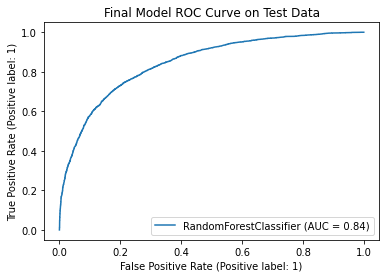

In [27]:
from sklearn.metrics import plot_roc_curve, roc_auc_score
ax = plot_roc_curve(clf_best, test_X, test_y)
ax.ax_.set_title("Final Model ROC Curve on Test Data");

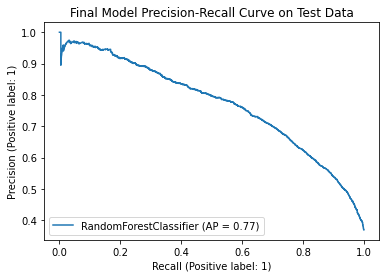

In [28]:
from sklearn.metrics import plot_precision_recall_curve
ax = plot_precision_recall_curve(clf_best, test_X, test_y)
ax.ax_.set_title("Final Model Precision-Recall Curve on Test Data");


**Display Feature Importance**<br/>

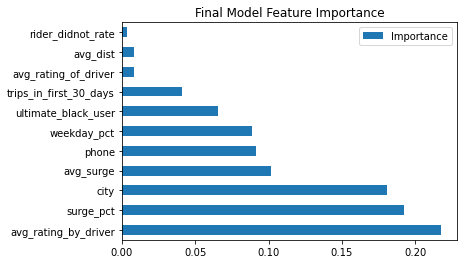

In [29]:
feature_df = pd.DataFrame(data={'Importance':clf_best.feature_importances_}, index=train_X.columns)
feature_df.sort_values(by='Importance', ascending=False, inplace=True)
feature_df.plot(kind='barh')
plt.title('Final Model Feature Importance'); print()

Some variables that come across as important are as follows:
<li>Average Rating by Driver: Undecisive as to direction from the EDA portion.
<li>Surge Percentage and Average Surge
<li>City where signed up
<li>Type of Phone Used  <br>
  However, I do not really have a good handle regarding how these factors actually impact the classification.



<h3>Retrain On All Available Using Logistic Regression on Training Data & Display Parameters and Feature Importances<h3/>

**Sklearn Implementation (No Confidence Intervals)**

In [30]:
clf_lr = LogisticRegression(penalty='none', solver='lbfgs', max_iter=1000)
clf_lr.fit(train_X,train_y)

print('Final Model (Logistic Regression) Scores')
print('Accuracy:  {0:.3f}'.format(accuracy_score(test_y, clf_lr.predict(test_X))))
print('F1 Score:  {0:.3f}'.format(f1_score(test_y, clf_lr.predict(test_X))))
print('Precision: {0:.3f}'.format(precision_score(test_y, clf_lr.predict(test_X))))
print('Recall:    {0:.3f}'.format(recall_score(test_y, clf_lr.predict(test_X))))

Final Model (Logistic Regression) Scores
Accuracy:  0.724
F1 Score:  0.568
Precision: 0.665
Recall:    0.495


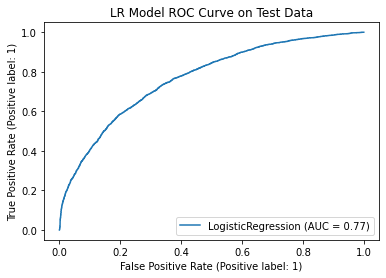

In [31]:
ax = plot_roc_curve(clf_lr, test_X, test_y)
ax.ax_.set_title("LR Model ROC Curve on Test Data");

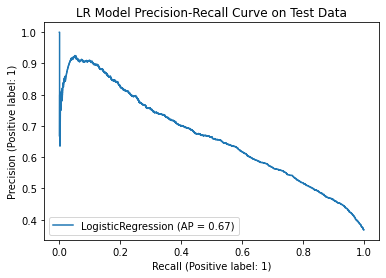

In [32]:
ax = plot_precision_recall_curve(clf_lr, test_X, test_y)
ax.ax_.set_title("LR Model Precision-Recall Curve on Test Data");

In [33]:
lr_coef = pd.Series(data = list(*clf_lr.coef_))
lr_coef.index = train_X.columns
lr_coef.sort_values(key = lambda x: abs(x), ascending=False)


phone                     1.148760
ultimate_black_user       0.929313
city                      0.863072
rider_didnot_rate        -0.717991
avg_surge                -0.178111
avg_rating_by_driver     -0.111360
trips_in_first_30_days    0.103495
avg_dist                 -0.034259
avg_rating_of_driver     -0.032198
surge_pct                 0.005212
weekday_pct               0.001121
dtype: float64

**Statsmodels Implementation (With Confidence Intervals)**

In [34]:
from scipy.special import expit, logit
from statsmodels.tools import add_constant
import statsmodels.api as sm

x = train_X
X = add_constant(x)
y = train_y

model = sm.Logit(y, X).fit(maxiter=500)
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.544388
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                 active   No. Observations:                39534
Model:                          Logit   Df Residuals:                    39522
Method:                           MLE   Df Model:                           11
Date:                Thu, 21 Oct 2021   Pseudo R-squ.:                  0.1722
Time:                        20:29:15   Log-Likelihood:                -21522.
converged:                       True   LL-Null:                       -25999.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -1.7357      0.180     -9.669      0.000      -2.088      

Almost all features can reject the null at 1% level. Some features which seem to have sizeable impacts are: city where signed up, phone used, ultimate black user status and whether the user rated a driver at all or not.